In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [22]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=5
                 )
#
client = Client(cluster)

In [23]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [24]:
parcels_index = 'lpass_filtered_05cpd'
#'filtered_itide_Tw30_sd_band04'
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df.head()


,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag
time,,,,,,,,,,,
2011-11-15,2000844,-67.226303,0.562500,0.0,0.0,0.0,0.0,-0.037399,0.0,-0.038937,0.0
2011-11-15,2001062,-68.788177,10.979167,0.0,0.0,0.0,0.0,-0.050828,0.0,-0.055424,0.0
2011-11-15,2001076,-62.904213,10.979167,0.0,0.0,0.0,0.0,-0.052928,0.0,-0.013808,0.0
2011-11-15,3001600,-60.772732,31.812500,0.0,0.0,0.0,0.0,0.026066,0.0,-0.010228,0.0
2011-11-15,4000298,-28.264765,-23.395834,0.0,0.0,0.0,0.0,-0.037163,0.0,0.025803,0.0


In [ ]:
df = df.reset_index().persist()

In [6]:
time = df.time.compute()

In [11]:
time = np.unique(time)

In [14]:
df0 = df.loc[time[0]].persist()

In [15]:
traj0 = df0.trajectory.values.compute()

In [16]:
df_traj0 = df[df.trajectory.isin(traj0)]

In [18]:
df_traj0 = df_traj0.persist()

In [19]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

In [20]:
df = df_traj0
# Remove duplicates found in dataframe and create flag column to check that dt is always 1/24
df_drop = df.reset_index().groupby('trajectory').apply(remove_duplicates#,meta=meta
                                   ).persist()
df_drop.head()

/dev/shm/pbs.437792.datarmor0/ipykernel_9494/2434329120.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_drop = df.reset_index().groupby('trajectory').apply(remove_duplicates#,meta=meta


trajectory        lat        lon    z  \
trajectory time                                                         
2000497    2011-11-15 00:00:00     2000497 -62.434929 -15.062500  0.0   
           2011-11-15 01:00:00     2000497 -62.431262 -15.056265  0.0   
           2011-11-15 02:00:00     2000497 -62.427809 -15.050383  0.0   
           2011-11-15 03:00:00     2000497 -62.424515 -15.044968  0.0   
           2011-11-15 04:00:00     2000497 -62.421201 -15.039949  0.0   

                                zonal_velocity  meridional_velocity  \
trajectory time                                                       
2000497    2011-11-15 00:00:00        0.000000             0.000000   
           2011-11-15 01:00:00        0.087452             0.109953   
           2011-11-15 02:00:00        0.080437             0.102737   
           2011-11-15 03:00:00        0.073801             0.100614   
           2011-11-15 04:00:00        0.069752             0.104266   

                                 waterdepth  zonal_velocity_hat_real  \
trajectory time                                                        
2000497    2011-11-15 00:00:00     0.000000                 0.038867   
           2011-11-15 01:00:00  4842.180176                 0.040745   
           2011-11-15 02:00:00  4842.180176                 0.042466   
           2011-11-15 03:00:00  4834.799316                 0.044016   
           2011-11-15 04:00:00  4842.786621                 0.045382   

                                zonal_velocity_hat_imag  \
trajectory time                                           
2000497    2011-11-15 00:00:00                      0.0   
           2011-11-15 01:00:00                      0.0   
           2011-11-15 02:00:00                      0.0   
           2011-11-15 03:00:00                      0.0   
           2011-11-15 04:00:00                      0.0   

                                meridional_velocity_hat_real  \
trajectory time                                                
2000497    2011-11-15 00:00:00                      0.056937   
           2011-11-15 01:00:00                      0.061144   
           2011-11-15 02:00:00                      0.065252   
           2011-11-15 03:00:00                      0.069234   
           2011-11-15 04:00:00                      0.073065   

                                meridional_velocity_hat_imag  
trajectory time                                               
2000497    2011-11-15 00:00:00                           0.0  
           2011-11-15 01:00:00                           0.0  
           2011-11-15 02:00:00                           0.0  
           2011-11-15 03:00:00                           0.0  
           2011-11-15 04:00:00                           0.0

In [10]:
print(df.zonal_velocity.size.compute(),df_drop.zonal_velocity.size.compute())

593657072 593657072


In [5]:
time = df.index.compute()

In [9]:
dT = np.unique(time).size

In [12]:
df.groupby('trajectory').apply(lambda df : np.unique(df.index).size).persist()

/dev/shm/pbs.297925.datarmor0/ipykernel_39672/3407009543.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df.groupby('trajectory').apply(lambda df : np.unique(df.index).size).persist()


Dask Series Structure:
npartitions=707
    int64
      ...
    ...  
      ...
      ...
dtype: int64
Dask Name: lambda, 707 tasks

In [15]:
V = 'hat'
df['zonal_velocity_'+V] = df['zonal_velocity_'+V+'_real']#+1j*df['zonal_velocity_'+V+'_imag']
df['energy_SSU'] = df['zonal_velocity_'+V].apply(lambda x : np.abs(x)**2)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('zonal_velocity_iprime_hat', 'float64'))

  warnings.warn(meta_warning(meta))


In [16]:
df['meridional_velocity_'+V] = df['meridional_velocity_'+V+'_real']#+1j*df['meridional_velocity_'+V+'_imag']
df['energy_SSV'] = df['meridional_velocity_'+V].apply(lambda x : np.abs(x)**2)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('meridional_velocity_iprime_hat', 'float64'))

  warnings.warn(meta_warning(meta))


In [17]:
df['energy'] = (df['energy_SSU']+df['energy_SSV'])

### Load Eulerian dataset

In [5]:
ds_low = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_low_variance.zarr')
#ds_low = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_lf.zarr')
ds_hf = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_hf_energy.zarr')
grd = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/rechunked/SSU_rot.zarr')[['XC','YC']]
ds_low['lon'] = 0*ds_low.face+grd.XC
ds_low['lat'] = 0*ds_low.face+grd.YC

ds_hf['lon'] = 0*ds_hf.face+grd.XC
ds_hf['lat'] = 0*ds_hf.face+grd.YC
ds_hf

/dev/shm/pbs.370772.datarmor0/ipykernel_15392/937849397.py:4: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/rechunked/SSU_rot.zarr')[['XC','YC']]


<xarray.Dataset>
Dimensions:     (j: 1080, i: 1080, face: 13)
Coordinates:
  * j           (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * i           (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    XC          (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    YC          (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    energy_SSU  (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    energy_SSV  (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    lat         (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lon         (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

In [35]:
ds_low

<xarray.Dataset>
Dimensions:       (j: 1080, i: 1080, face: 13)
Coordinates:
  * j             (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * i             (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    XC            (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    YC            (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
  * face          (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    energy        (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    energy_SSU    (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    energy_SSV    (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    lat           (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lon           (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    variance_SSU  (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    variance_SSV  (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>

In [79]:
ds_hf['energy_hf'] = 0.5*(ds_hf.energy_SSU+ds_hf.energy_SSV)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

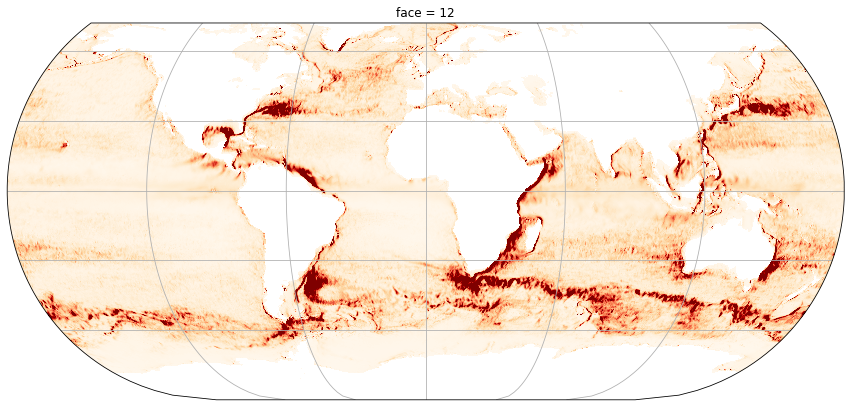

In [9]:
pl.plot_pretty(ds_low.energy_SSV,cmap='OrRd',vmax=0.15,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

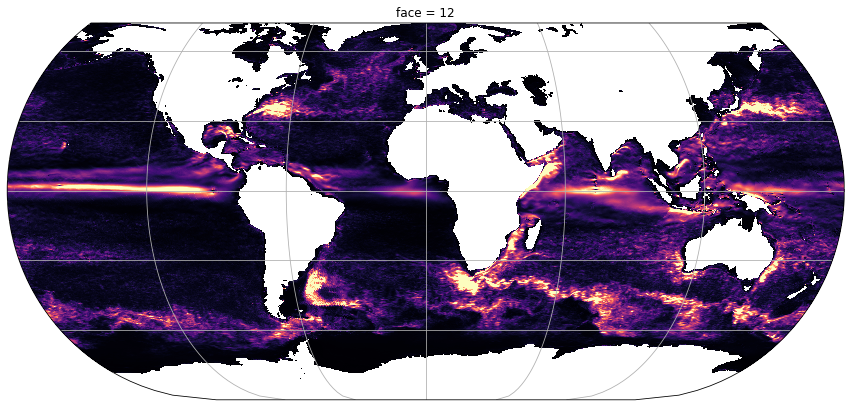

In [10]:
pl.plot_pretty(ds_low.variance_SSU,cmap='magma',vmax=0.15,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

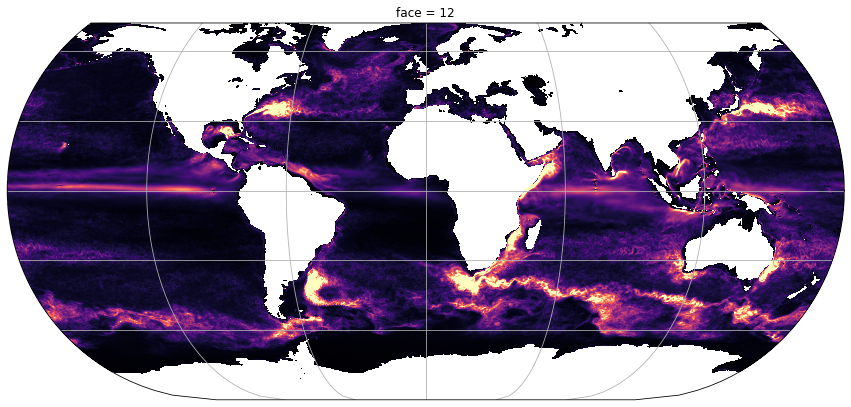

In [7]:
pl.plot_pretty(0.5*(ds_low.variance_SSU+ds_low.variance_SSV),cmap='magma',vmax=0.15,land=False
              )

In [5]:
ds_hf['XC'] = ds_low.XC
ds_hf['YC'] = ds_low.YC

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

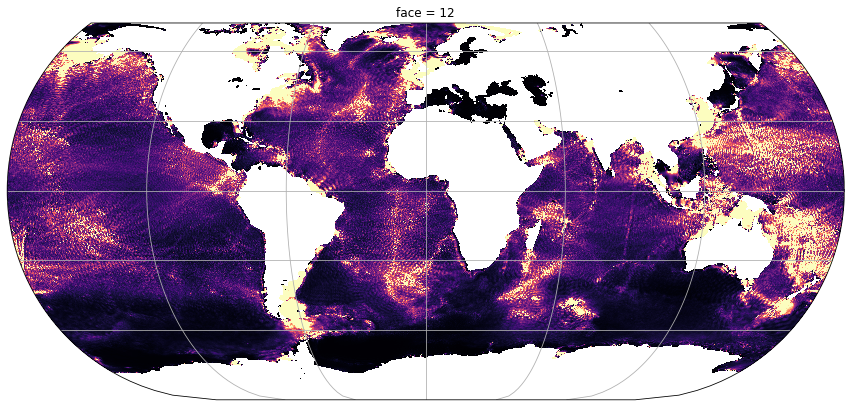

In [6]:
pl.plot_pretty(ds_hf.energy_SSU,cmap='magma',vmax=0.02,land=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

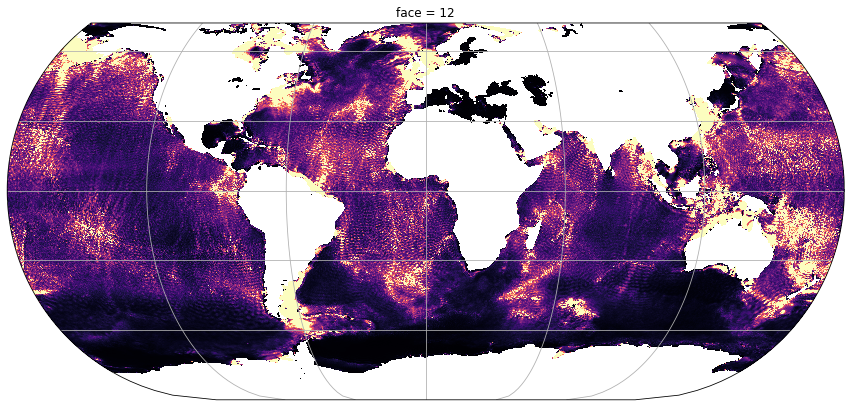

In [7]:
pl.plot_pretty(ds_hf.energy_SSV,cmap='magma',vmax=0.02,land=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

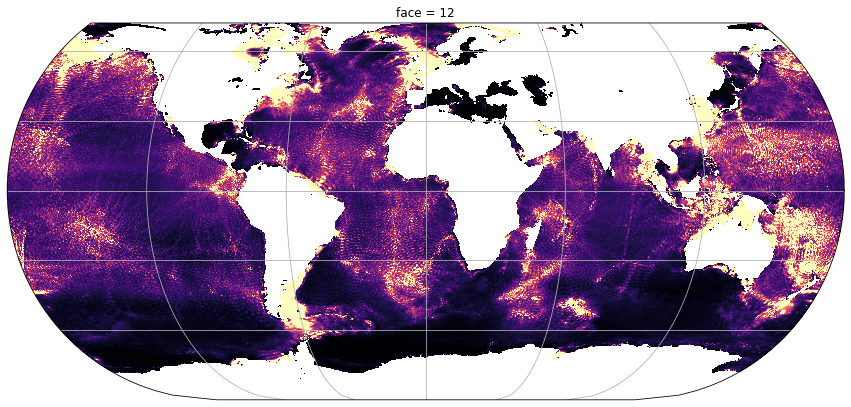

In [9]:
pl.plot_pretty(0.5*(ds_hf.energy_SSU+ds_hf.energy_SSV),cmap='magma',vmax=0.02,land=False)

### Binning

In [9]:
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
V = 'energy'

In [10]:
N = histogram(ds_low.lon.rename('lon'), ds_low.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

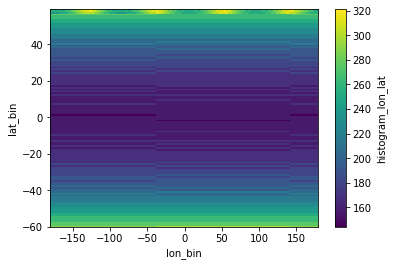

In [38]:
N.plot(y='lat_bin')

In [11]:
ds_binned = (histogram(ds_low.lon.rename('lon'), ds_low.lat.rename('lat'),bins=[lon_bins, lat_bins],
                       weights=2*ds_low[V].fillna(0.),
                       dim=['i', 'j', 'face'])/(N)).rename('E_%s'%V).persist()

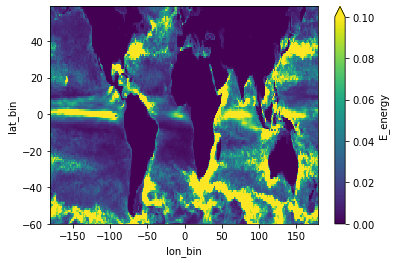

In [18]:
ds_binned.plot(y='lat_bin',vmax=0.1)

In [19]:
ds_binned = ds_binned.where(ds_binned>0)

In [20]:
dsE = xr.Dataset({'E_count':N,'E_'+V:ds_binned})
dsE = dsE.compute()
dsE

<xarray.Dataset>
Dimensions:       (lon_bin: 359, lat_bin: 119)
Coordinates:
  * lon_bin       (lon_bin) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bin       (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    E_count       (lon_bin, lat_bin) int64 288 276 276 264 ... 264 276 252 251
    E_iprime_hat  (lon_bin, lat_bin) float64 0.03132 0.03988 ... 0.01456 0.01818

In [21]:
Vl = 'energy'
_df = df[[Vl,'lon','lat','waterdepth','trajectory']]
_df.head()

,energy,lon,lat,waterdepth,trajectory
time,,,,,
2011-11-15,0.003708,-18.187500,-58.170475,0.0,3000405
2011-11-15,0.024337,24.520834,-47.424526,0.0,3001448
2011-11-15,0.007948,-26.520834,-10.810700,0.0,5000215
2011-11-15,0.011178,-9.854167,-4.132948,0.0,5000622
2011-11-15,0.004836,-3.604167,-18.233944,0.0,5000757


In [22]:
def binning(_df,binsize):
    #lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = _df['lon'].map_partitions(pd.cut, bins=lon_bins)
    _df['lat_cut'] = _df['lat'].map_partitions(pd.cut, bins=lat_bins)
    _df = _df.drop(columns=['lon','lat','trajectory']) # ,'h'
    return _df
_df = binning(_df,dl).persist()

In [23]:
df_mean = _df.groupby(['lon_cut','lat_cut']).mean()
df_mean = df_mean.reset_index().persist()

In [24]:
df_count = _df.groupby(['lon_cut','lat_cut']).count().reset_index().persist()

In [25]:
df_count['lon_bin'] = df_count.lon_cut.apply(lambda x :x.mid)
df_count['lat_bin'] = df_count.lat_cut.apply(lambda x :x.mid)
df_count = df_count.drop(columns=['lon_cut','lat_cut']).compute()
df_count.head()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

,energy,waterdepth,lon_bin,lat_bin
0,217,217,-179.5,-59.5
1,215,215,-179.5,-58.5
2,186,186,-179.5,-57.5
3,488,488,-179.5,-56.5
4,525,525,-179.5,-55.5


In [26]:
df_mean['lon_bin'] = df_mean.lon_cut.apply(lambda x :x.mid)
df_mean['lat_bin'] = df_mean.lat_cut.apply(lambda x :x.mid)
df_mean = df_mean.drop(columns=['lon_cut','lat_cut']).persist()
df_mean.head()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

,energy,waterdepth,lon_bin,lat_bin
0,0.028496,4346.939804,-179.5,-59.5
1,0.043391,4967.515698,-179.5,-58.5
2,0.078799,5021.588710,-179.5,-57.5
3,0.103857,5057.304303,-179.5,-56.5
4,0.154157,5231.297143,-179.5,-55.5


In [27]:
df_mean = df_mean.compute()

In [28]:
dsL = df_mean.set_index(['lon_bin','lat_bin']).to_xarray().unstack()
dsL['L_count'] = df_count.set_index(['lon_bin','lat_bin']).to_xarray().unstack()['waterdepth']

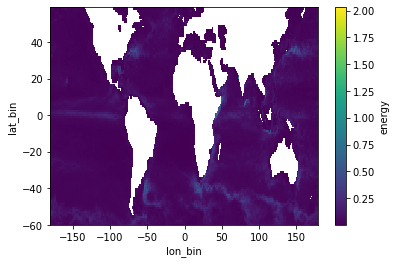

In [29]:
dsL[Vl].plot(y='lat_bin')

In [30]:
ds = xr.merge([dsE,dsL.rename({Vl:'L_'+V})])
#ds = ds_binned
ds

<xarray.Dataset>
Dimensions:       (lon_bin: 359, lat_bin: 119)
Coordinates:
  * lon_bin       (lon_bin) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bin       (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    E_count       (lon_bin, lat_bin) int64 288 276 276 264 ... 264 276 252 251
    E_iprime_hat  (lon_bin, lat_bin) float64 0.03132 0.03988 ... 0.01456 0.01818
    L_iprime_hat  (lon_bin, lat_bin) float64 0.0285 0.04339 ... 0.01865 0.02178
    waterdepth    (lon_bin, lat_bin) float64 4.347e+03 4.968e+03 ... 3.745e+03
    L_count       (lon_bin, lat_bin) int64 217 215 186 488 ... 5994 6380 2066

In [31]:
ds.to_netcdf('/home1/datawork/zcaspar/mit4320/%s_low_variance_binned_dl%s.nc'%(V,str(dl)))

In [21]:
#client.restart()
#
cluster.close()